# Custom Data Loader for DeepLesion Dataset

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile 
import cv2
import shutil
import torch.utils.data.dataset as dataset
import re

In [3]:
# specifying the zip file name 
file_name = "./Key_slices.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip:  
    if os.path.isdir('Key_slices') == 0:
    # extracting all the files 
        print('Extracting all the files now...') 
        zip.extractall() 
        print('Done!') 
    else:
        print('File has already extracted.')

File has already extracted.


## Visualization of Key Slice

In [4]:
image_directory = './Key_slices'
info_file = './DL_info.csv'

In [5]:
class CTImage:
    def __init__(self, image_directory, info_file, study_type = 'all', patient_metadata = False):
        self.image_directory = image_directory
        self.info_file = pd.read_csv(info_file)
        if study_type != 'all':
            self.info_file = self.info_file[self.info_file.Study_index == study_type]
        self.patient_metadata = patient_metadata
        
    def get_by_user(self, user_idx):
        file_subset = self.info_file[self.info_file.Patient_index == user_idx]
        image_list = file_subset.File_name.values
        if self.patient_metadata:
            gender_list = file_subset.Patient_gender.values
            age_list = file_subset.Patient_age.values
        images = []
        for image_name in image_list:
            image_path = os.path.join(self.image_directory, image_name)
            images.append(plt.imread(image_path))
        if self.patient_metadata:
            return((images, gender_list, age_list))
        else:
            return((images,))
    
    def get_val_by_lesion(self, lesion_type = 'bone'):
        study_dict = {'bone':1, 'abdomen':2, 'mediastinum': 3,'liver':4, 'lung':5, 'kidney': 6, 'soft_tissue':7, 'pelvis':8}
        val_file = self.info_file[self.info_file.Train_Val_Test == 2]
        file_subset = images_list = val_file[val_file.Coarse_lesion_type == study_dict[lesion_type]]
        images_list = file_subset.File_name.values
        if self.patient_metadata:
            gender_list = file_subset.Patient_gender.values
            age_list = file_subset.Patient_age.values
        images = []
        for image_name in images_list:
            image_path = os.path.join(self.image_directory, image_name)
            images.append(plt.imread(image_path))
        if self.patient_metadata:
            return((images, gender_list, age_list))
        else:
            return((images,))
    
    def get_test_by_lesion(self, lesion_type = 'bone'):
        study_dict = {'bone':1, 'abdomen':2, 'mediastinum': 3,'liver':4, 'lung':5, 'kidney': 6, 'soft_tissue':7, 'pelvis':8}
        test_file = self.info_file[self.info_file.Train_Val_Test == 3]
        file_subset = test_file[test_file.Coarse_lesion_type == study_dict[lesion_type]]
        images_list = file_subset.File_name.values
        if self.patient_metadata:
            gender_list = file_subset.Patient_gender.values
            age_list = file_subset.Patient_age.values
        images = []
        for image_name in images_list:
            image_path = os.path.join(self.image_directory, image_name)
            images.append(plt.imread(image_path))
        if self.patient_metadata:
            return((images, gender_list, age_list))
        else:
            return((images,))

    def get_train(self):
        file_subset = self.info_file[self.info_file.Train_Val_Test == 1]
        images_list = file_subset.File_name.values
        images = []
        if self.patient_metadata:
            gender_list = file_subset.Patient_gender.values
            age_list = file_subset.Patient_age.values
        for image_name in images_list:
            image_path = os.path.join(self.image_directory, image_name)
            images.append(plt.imread(image_path))
        if self.patient_metadata:
            return((images, gender_list, age_list))
        else:
            return((images,))

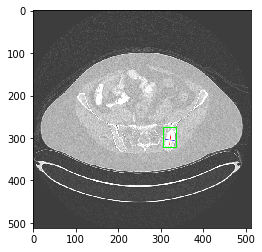

In [6]:
ct_images = CTImage(image_directory, info_file, patient_metadata = False)
plt.imshow(ct_images.get_test_by_lesion('bone')[0][1]) #Visualize the second CT image amongst bone lesion CTs
plt.show()

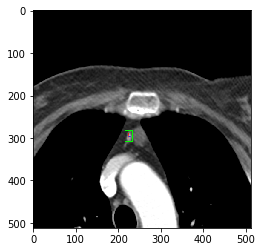

In [7]:
plt.imshow(ct_images.get_by_user(1)[0][1])

## Separate Dataset
In DeepLesion dataset, the official separation of training, validation and test set is given in `DL_info.csv`, with the column `Train_Val_Test`.

In [27]:
csv_path = "./DL_info.csv"
Image_slices_dir = "./Key_slices"
train_data = "./data/train"
valid_data = "./data/valid"
test_data = "./data/test"

In [28]:
df = pd.read_csv(csv_path)
train_df = df[df['Train_Val_Test']==1]
validation_df = df[df['Train_Val_Test']==2]
test_df = df[df['Train_Val_Test']==3]

print(len(train_df.index))
print(len(validation_df.index))
print(len(test_df.index))

print(len(train_df.index)+len(validation_df.index)+len(test_df.index))

22919
4889
4927
32735


./Key_slices/000003_01_01_016.png


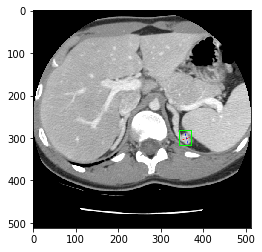

(512, 512, 3)


'./data/train'

In [29]:
file_name = os.path.join(Image_slices_dir, train_df.iloc[0]['File_name'])        
print(file_name)
image = cv2.imread(file_name)
plt.figure()
plt.imshow(image)
plt.show()
print(image.shape)
shutil.copy(file_name, train_data)

In [30]:
for i in range(len(train_df.index)):
    file_name = os.path.join(Image_slices_dir, train_df.iloc[i]['File_name']) 
    shutil.copy(file_name, train_data)

for i in range(len(validation_df.index)):
    file_name = os.path.join(Image_slices_dir, validation_df.iloc[i]['File_name']) 
    shutil.copy(file_name, valid_data)

for i in range(len(test_df.index)):
    file_name = os.path.join(Image_slices_dir, test_df.iloc[i]['File_name']) 
    shutil.copy(file_name, test_data)

## Custom DataLoader

In [45]:
class ToTensor(object):
    def __call__(self, sample):
        image, lesions = sample['image'], sample['lesions']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'lesions': torch.from_numpy(lesions)}

class ImageDataset(dataset.Dataset):
    def __init__ (self, root_dir, dataset_type, csv_file=csv_path):
        self.root_dir = root_dir
        self.csv_path = csv_path
        self.df = pd.read_csv(csv_path)[df['Train_Val_Test']==dataset_type]
    def __len__(self):
        return len(self.df.index)
    def __getitem__(self, idx):
        # read file
        file_name = os.path.join(self.root_dir, self.df.iloc[idx]['File_name'])        
        image = cv2.imread(file_name)
        
        # find all boudning boxes
        lesions = []
        new_df = self.df[self.df['File_name']==self.df.iloc[idx]['File_name']]
        for i in range(len(new_df.index)):
            coordinates_str = (re.split(',',new_df.iloc[i]['Bounding_boxes']))
            coordinates = [ float(x) for x in coordinates_str]
            # print (coordinates)
            lesions.append(coordinates)
            
        lesions = np.asarray(lesions)
        sample = {'image':image, 'lesions':lesions}
        
        return sample

In [48]:
train_dataset = ImageDataset(root_dir=Image_slices_dir, dataset_type=1)
validation_dataset = ImageDataset(root_dir=Image_slices_dir, dataset_type=2)
test_dataset = ImageDataset(root_dir=Image_slices_dir, dataset_type=3)


print(len(train_dataset))
print(len(validation_dataset))
print(len(test_dataset))
print(len(train_dataset)+len(validation_dataset)+len(test_dataset))

22919
4889
4927
32735


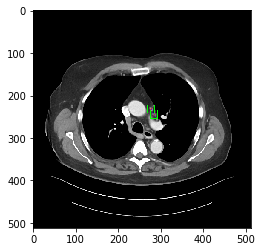

[[269.885 223.677 286.907 242.495]
 [276.496 236.196 294.309 255.654]]


In [57]:
image = train_dataset[28]["image"]
plt.figure()
plt.imshow(image)
plt.show()
lesions= train_dataset[28]["lesions"]
print(lesions)